# PySparkによる週販累計

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, TimestampType, StringType
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib

# spark initialization
spark = SparkSession.builder.appName("gamedata").getOrCreate()
# load master database
hard_sales = spark.read.parquet("../database/parquet/hard_sales")
# hard_info_df = spark.read.parquet("../database/parquet/hard_info")

23/08/18 17:11:16 WARN Utils: Your hostname, apricot.local resolves to a loopback address: 127.0.0.1; using 192.168.0.41 instead (on interface en0)
23/08/18 17:11:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/08/18 17:11:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/18 17:11:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## ハード毎､日付順で累計する

- hwでパーティション分離､日付順で､Windowの先頭から現在位置までのWindowを作る
- 上記のWindowsを使ってunitsを合計し､cumsumカラムとして追加
- end_date順に並べる

## hw毎にpivotする

In [2]:
hard_cumsum = hard_sales.groupBy("end_date").pivot("hw").sum("sum_units").sort("end_date")
hard_cumsum.orderBy("end_date").tail(5)

23/08/18 17:11:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(end_date=datetime.date(2023, 7, 9), 3DS=24387278, DC=None, DS=None, GB=None, GBA=None, GC=None, N64=None, NeoGeoP=None, PKS=None, PS=None, PS2=None, PS3=None, PS4=9445555, PS5=3901335, PSP=None, SATURN=None, Switch=29859091, Vita=None, WS=None, Wii=None, WiiU=None, XB360=None, XBOne=None, XSX=471540, Xbox=None),
 Row(end_date=datetime.date(2023, 7, 16), 3DS=24387308, DC=None, DS=None, GB=None, GBA=None, GC=None, N64=None, NeoGeoP=None, PKS=None, PS=None, PS2=None, PS3=None, PS4=9446748, PS5=3946794, PSP=None, SATURN=None, Switch=29924017, Vita=None, WS=None, Wii=None, WiiU=None, XB360=None, XBOne=None, XSX=472409, Xbox=None),
 Row(end_date=datetime.date(2023, 7, 23), 3DS=24387330, DC=None, DS=None, GB=None, GBA=None, GC=None, N64=None, NeoGeoP=None, PKS=None, PS=None, PS2=None, PS3=None, PS4=9451057, PS5=3993355, PSP=None, SATURN=None, Switch=29995197, Vita=None, WS=None, Wii=None, WiiU=None, XB360=None, XBOne=None, XSX=473567, Xbox=None),
 Row(end_date=datetime.date(2023, 7, 30),

## データ範囲に発売日を含まないものを除く

In [3]:
hard_cumsum = hard_cumsum.select("end_date",
    "PS5", "XSX", "Switch",
    "XBOne", "PS4", "WiiU",
    "Vita", "3DS", 
    "Wii", "PS3", "XB360",
    "DS", "PSP",
    "Xbox", "GC", "GBA", "PS2",
    "WS", "PKS", "DC", "NeoGeoP") 

## pandas DFに変換してplot

<Axes: xlabel='end_date'>

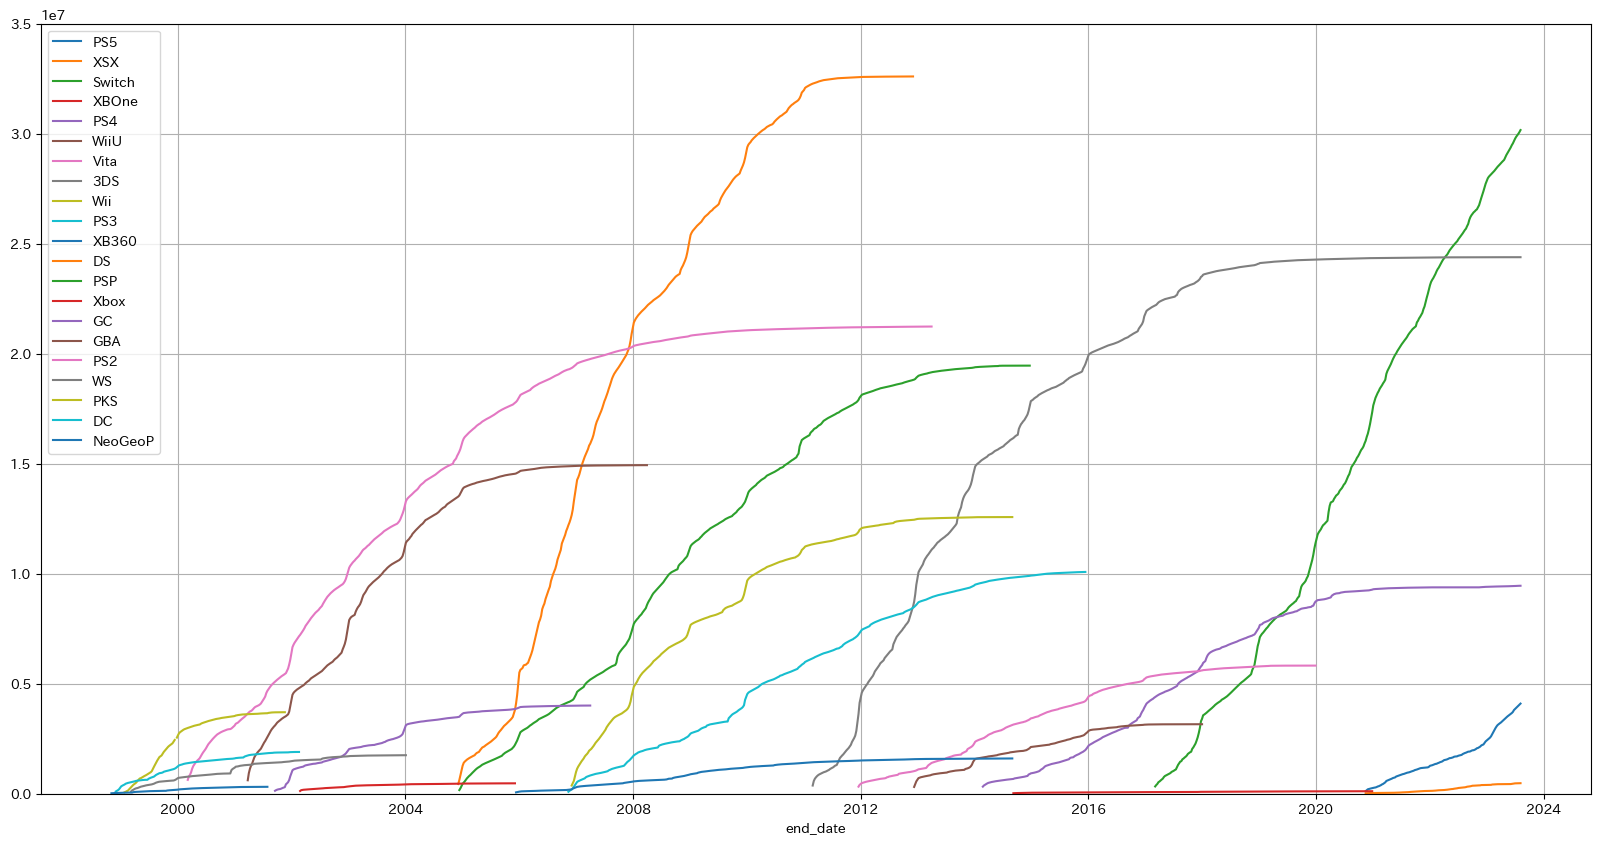

In [4]:
pdf = hard_cumsum.toPandas().set_index("end_date")
pdf.plot(figsize=(20, 10), grid=True, kind="line", ylim=[0, 35000000])

# 発売日からの相対累積グラフ

## ハード情報テーブルをJOIN

発売日を含んだ hard_info_dfをハード累積を含んだ hard_sumをjoinする｡

(集計日 - 発売日)を delta_dayとして計算してカラム追加する｡
発売日をデータ範囲に含まないものを取り除く｡

## pivotする

縦軸はdelta_dayなので groupBy(delta_day)する｡
hwを横に並べるので pivot("hw")する｡
データは累積値をそのまま使うので sum("cumsum")｡

In [5]:
hard_pivot_delta = hard_sales.groupBy("delta_week").pivot("hw").sum("sum_units").sort("delta_week").select(
    "delta_week",
    "PS5", "XSX", "Switch",
    "XBOne", "PS4", "WiiU",
    "Vita", "3DS", 
    "Wii", "PS3", "XB360",
    "DS", "PSP",
    "Xbox", "GC", "GBA", "PS2",
    "WS", "PKS", "DC", "NeoGeoP")

In [6]:
hard_pivot_delta.show()

+----------+------+-----+-------+-----+------+------+------+-------+-------+------+------+-------+-------+------+-------+-------+-------+------+------+------+-------+
|delta_week|   PS5|  XSX| Switch|XBOne|   PS4|  WiiU|  Vita|    3DS|    Wii|   PS3| XB360|     DS|    PSP|  Xbox|     GC|    GBA|    PS2|    WS|   PKS|    DC|NeoGeoP|
+----------+------+-----+-------+-----+------+------+------+-------+-------+------+------+-------+-------+------+-------+-------+-------+------+------+------+-------+
|         0|118085|20534| 330637|23562|322083|308570|321407| 371326| 371936| 88443| 62135| 441485| 166074|123929| 133719| 611504| 630552|102655| 64340|101490|  21471|
|         1|160976|24218| 394057|27136|374780|439223|402794| 577413| 481004|131821| 74455| 622716| 247429|161076| 162928| 935190| 784797|154012| 86116|133066|  26159|
|         2|201435|27811| 444878|28672|405546|561579|442900| 681825| 582960|169082| 84490| 843011| 349283|172006| 184265|1132611| 856577|177204|115649|161061|  29324

<Axes: xlabel='delta_week'>

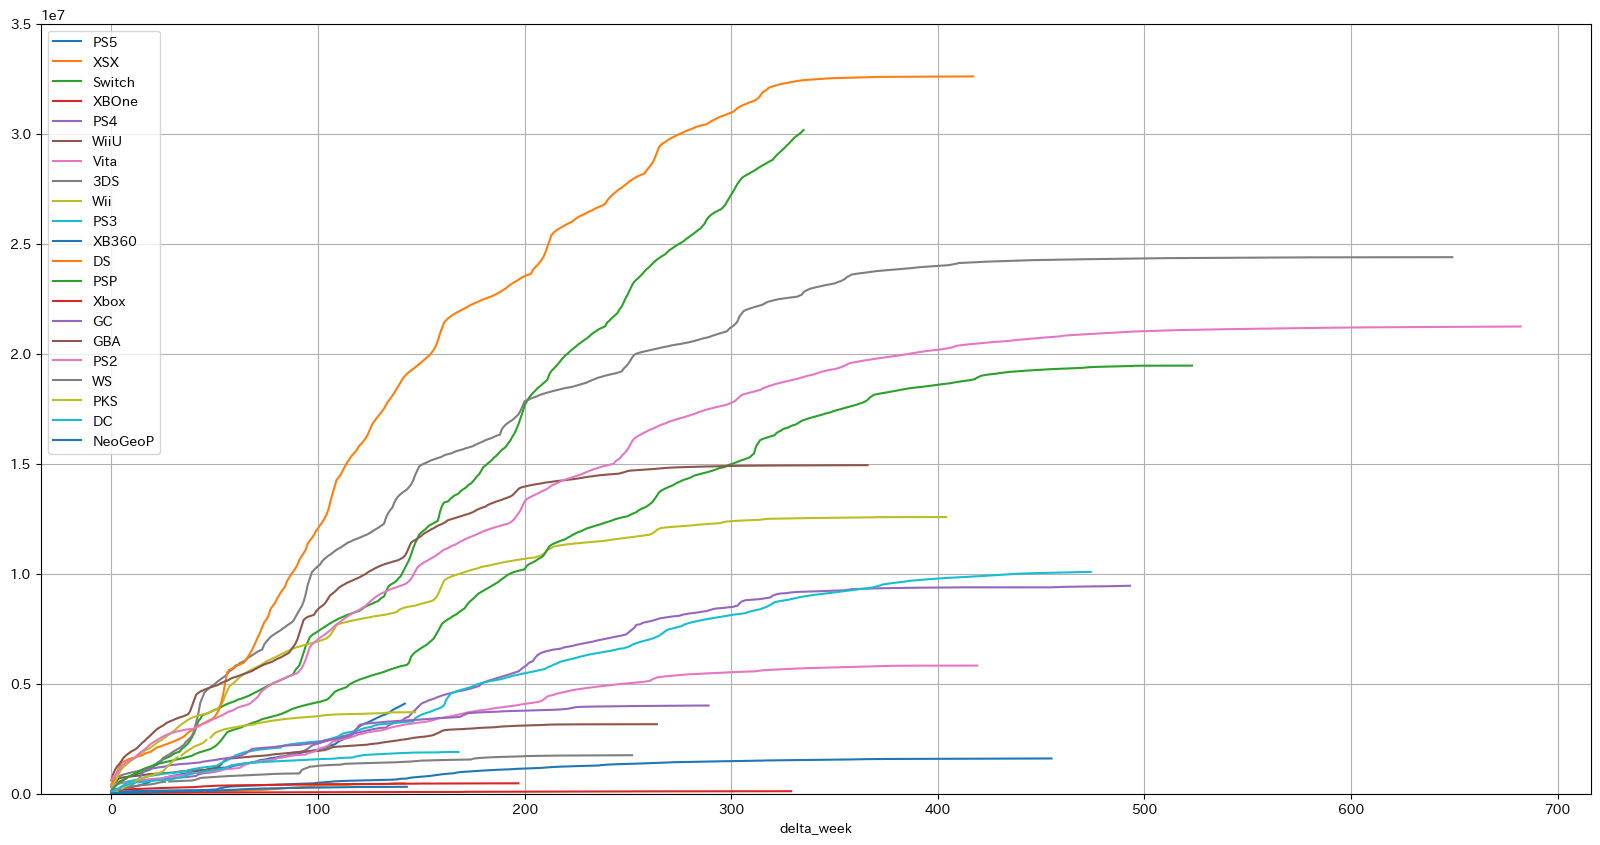

In [7]:
pd_delta = hard_pivot_delta.toPandas().set_index("delta_week")
pd_delta.plot(figsize=(20, 10), grid=True, kind="line", ylim=[0, 35000000])

In [8]:
active_hard = hard_pivot_delta.select("delta_week", "PS5", "Switch", "XSX")
active_hard.show()

+----------+------+-------+-----+
|delta_week|   PS5| Switch|  XSX|
+----------+------+-------+-----+
|         0|118085| 330637|20534|
|         1|160976| 394057|24218|
|         2|201435| 444878|27811|
|         3|213328| 524371|29433|
|         4|224384| 556633|30844|
|         5|241962| 601904|31219|
|         6|255150| 644604|31424|
|         7|265782| 684971|31558|
|         8|276946| 759188|31667|
|         9|284274| 806541|31827|
|        10|301622| 831798|32251|
|        11|327570| 859062|33350|
|        12|341094| 886502|33664|
|        13|363984| 911776|33800|
|        14|389021| 940069|34030|
|        15|422859| 989509|35517|
|        16|445408|1016473|36083|
|        17|483259|1041209|36801|
|        18|517916|1077352|38730|
|        19|580211|1102506|40009|
+----------+------+-------+-----+
only showing top 20 rows



<Axes: xlabel='delta_week'>

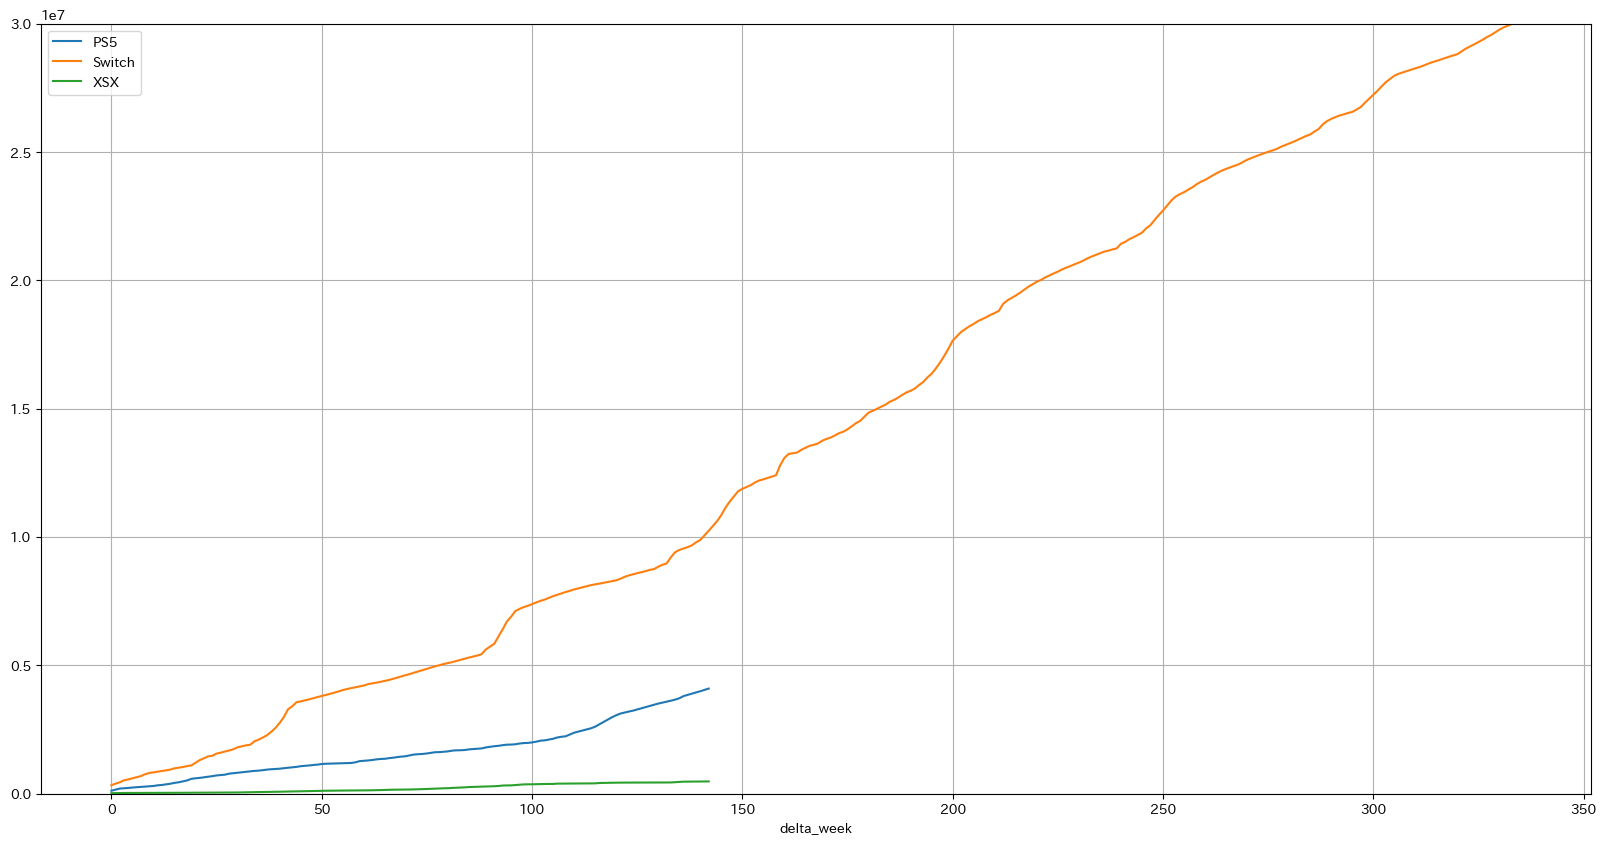

In [9]:
active_pd = active_hard.toPandas().set_index("delta_week")
active_pd.plot(figsize=(20, 10), grid=True, kind="line", ylim=[0, 30000000])

In [10]:
nintendo_hard = hard_pivot_delta.select("delta_week", "Switch", "WiiU", "Wii", "DS", "3DS")
nintendo_hard.show()

+----------+-------+------+-------+-------+-------+
|delta_week| Switch|  WiiU|    Wii|     DS|    3DS|
+----------+-------+------+-------+-------+-------+
|         0| 330637|308570| 371936| 441485| 371326|
|         1| 394057|439223| 481004| 622716| 577413|
|         2| 444878|561579| 582960| 843011| 681825|
|         3| 524371|635290| 786039|1056428| 746767|
|         4| 556633|709001| 989118|1269845| 801423|
|         5| 601904|730490|1135671|1401962| 844601|
|         6| 644604|747125|1232646|1460950| 877360|
|         7| 684971|759460|1313160|1508241| 902680|
|         8| 759188|771174|1394541|1550496| 923955|
|         9| 806541|782266|1469714|1585947| 949674|
|        10| 831798|792433|1538692|1616738| 975393|
|        11| 859062|801928|1602541|1642295| 991772|
|        12| 886502|811456|1690879|1672472|1008237|
|        13| 911776|820545|1752238|1700752|1033333|
|        14| 940069|829112|1801988|1726027|1061201|
|        15| 989509|839284|1865929|1748799|1085427|
|        16|

<Axes: xlabel='delta_week'>

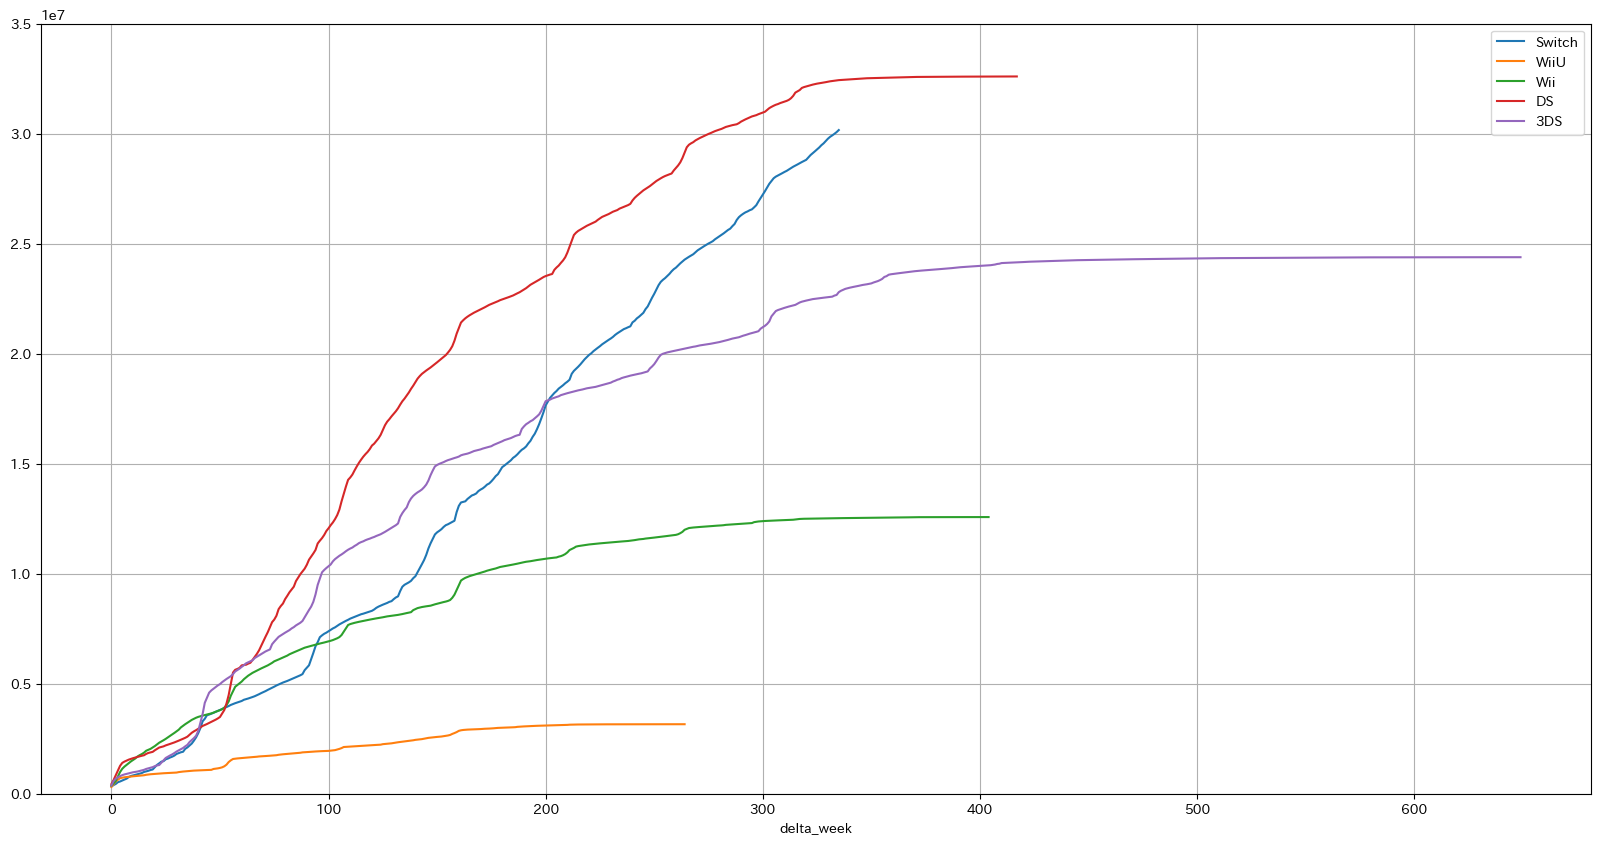

23/08/20 15:09:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 193537 ms exceeds timeout 120000 ms
23/08/20 15:09:05 WARN SparkContext: Killing executors is not supported by current scheduler.
23/08/20 15:09:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [11]:
nintendo_pd = nintendo_hard.toPandas().set_index("delta_week")
nintendo_pd.plot(figsize=(20, 10), grid=True, kind="line", ylim=[0, 35000000])